\begin{center} 
Chun-Yuan (Scott) Chiu 
\end{center}
\begin{center} 
chunyuac@andrew.cmu.edu 
\end{center}

# 1. {-}

In [2]:
!pip install pmdarima > /dev/null

We download the data, compute the log-return and run the augmented Dickey-Fuller test. The result indicates there is no unit root in the time series. 

In [1]:
import statsmodels.tsa.api as smt
import pandas_datareader as pdr
import numpy as np

ticker = '^gspc'
start = '2020-01-01'
end = '2021-04-16'
shf = 1

adjclose = pdr.get_data_yahoo(ticker, start, end)['Adj Close']
logret = np.log(adjclose/adjclose.shift(shf)).dropna()

smt.stattools.adfuller(logret)

(-4.727019298706826,
 7.48488347166799e-05,
 8,
 315,
 {'1%': -3.451281394993741,
  '5%': -2.8707595072926293,
  '10%': -2.571682118921643},
 -1593.4382263462237)

In [2]:
import warnings
warnings.filterwarnings('ignore')

We then present the time series plots, and the ACF and the PACF plots. We do this 3 times for data from different windows: the full period 1/1/2020 - 4/16/2021, the first half of the full period, and the second half. As a result, the ACF given the full period data is very similar to the one only given the first half, but not so much with the second half. Since the unusual 2020 March market condition is only in the first half but not the second half, it makes sense for them to have different autocorrelation structures. In short, the log-return time series from the full period is not weakly stationary. 

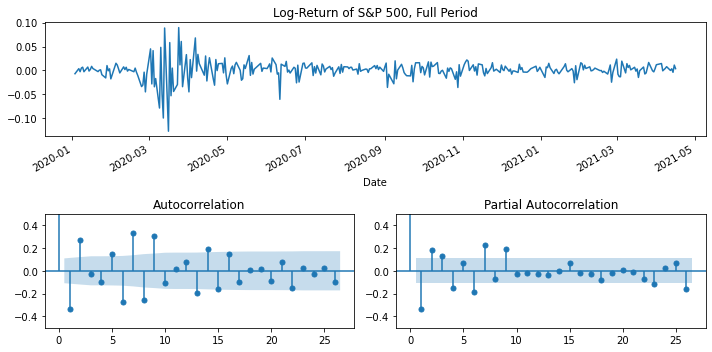

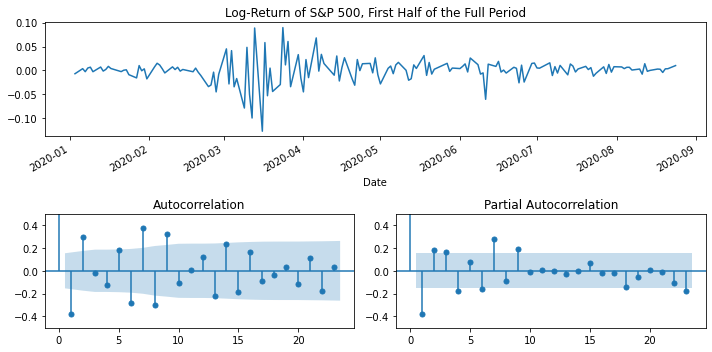

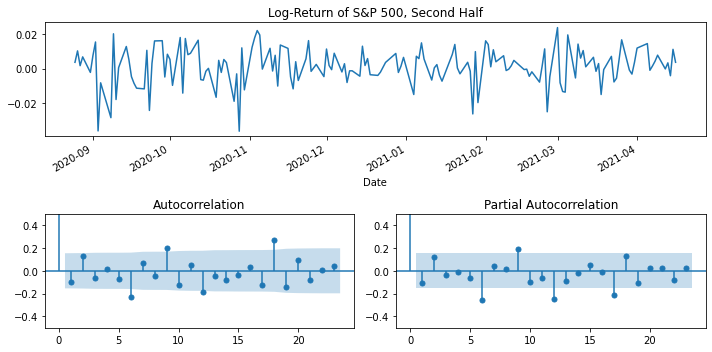

In [3]:
from pandas import Series
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt

def tsplot(ts, title, acf_ylim=(-0.2, 0.2)):
    fig = plt.figure(figsize=(10, 5))
    layout = (2,2)
    ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
    pacf_ax = plt.subplot2grid(layout, (1,1))
    acf_ax = plt.subplot2grid(layout, (1,0))

    Series(ts).plot(ax=ts_ax)
    smt.graphics.plot_acf(ts, ax=acf_ax)
    smt.graphics.plot_pacf(ts, ax=pacf_ax)
    ts_ax.set(title=title)
    pacf_ax.set(ylim=acf_ylim)
    acf_ax.set(ylim=acf_ylim)

    plt.tight_layout()
    plt.show()

tsplot(logret, title='Log-Return of S&P 500, Full Period', acf_ylim=(-0.5, 0.5))
tsplot(logret[:162], title='Log-Return of S&P 500, First Half of the Full Period', acf_ylim=(-0.5, 0.5))
tsplot(logret[162:], title='Log-Return of S&P 500, Second Half', acf_ylim=(-0.5, 0.5))

Below we call `pmdarima.auto_arima` to select and train an ARIMA model for the log-returns. The selected model is MA(2) which is then used to compute forecasts for April 2021. We present the log-return time series and the forecasts in the plot. For better visualization, only log-returns from the last 50 dates are presented. 

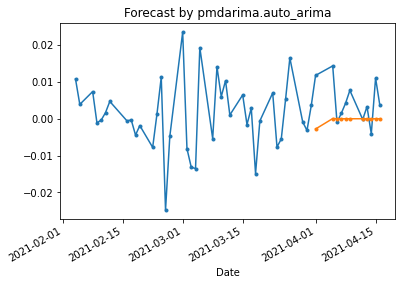

In [5]:
from pmdarima.model_selection import train_test_split
from pandas import Series
import pmdarima as pm

test_size = 11

train, test = train_test_split(logret, test_size=test_size)
model = pm.auto_arima(train, seasonal=False)

forecasts = Series(model.predict(test_size), index=logret.tail(test_size).index)

ax = logret.tail(50).plot(style='.-', title='Forecast by pmdarima.auto_arima')
forecasts.plot(ax=ax, style='.-')
pass

In [5]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  313
Model:               SARIMAX(0, 0, 2)   Log Likelihood                 805.501
Date:                Thu, 22 Apr 2021   AIC                          -1605.003
Time:                        03:40:48   BIC                          -1593.764
Sample:                             0   HQIC                         -1600.511
                                - 313                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2704      0.028     -9.660      0.000      -0.325      -0.216
ma.L2          0.3151      0.027     11.723      0.000       0.262       0.368
sigma2         0.0003   1.21e-05     28.216      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):              1052.43
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               0.13   Skew:                            -0.85
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# 2. {-}

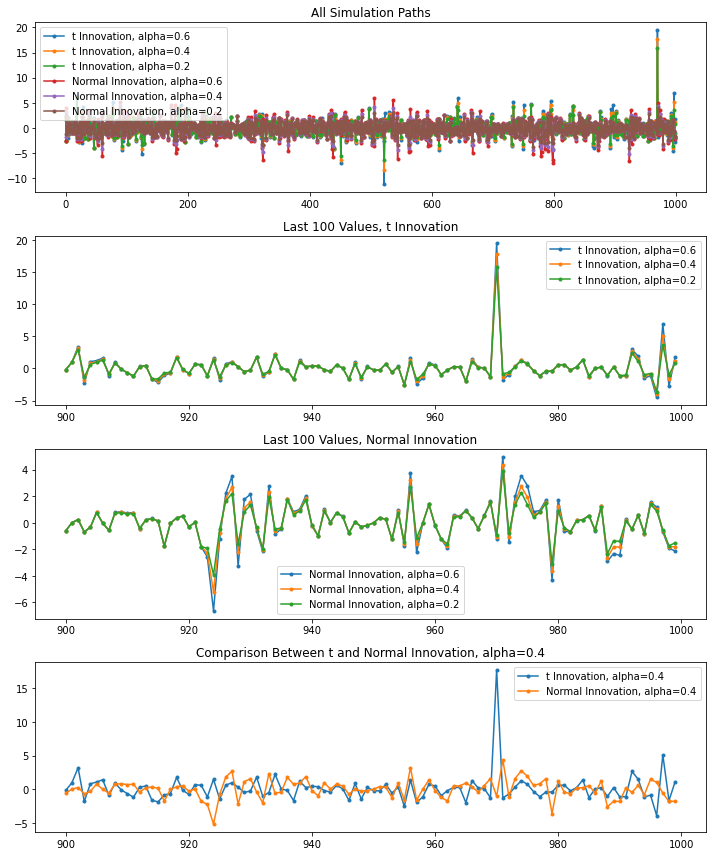

In [1]:
from pandas import DataFrame
from arch.univariate import GARCH, Normal
from scipy.stats import norm, t
import matplotlib.pyplot as plt
import numpy as np
import numpy.random

seed = 3
alphas = [.6, .4, .2]
paths = {}

# t innovation
for alpha in alphas:
    numpy.random.seed(seed)
    model = GARCH(1, 0, 0)
    y, variance = model.simulate([1, alpha], 1000, rng=lambda size: t.rvs(df=4, size=size)/np.sqrt(2))
    paths[f't Innovation, alpha={alpha}'] = y

# normal innovation
for alpha in alphas:
    numpy.random.seed(seed)
    model = GARCH(1, 0, 0)
    y, variance = model.simulate([1, alpha], 1000, rng=lambda size: norm.rvs(size=size))
    paths[f'Normal Innovation, alpha={alpha}'] = y
    
df = DataFrame(paths)    
    
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 12))

df.plot(style='.-', ax=ax1, title='All Simulation Paths')
df[[col for col in df.columns if 't Innov' in col]].iloc[-100:, :].plot(style='.-', ax=ax2, title='Last 100 Values, t Innovation')
df[[col for col in df.columns if 'Normal Innov' in col]].iloc[-100:, :].plot(style='.-', ax=ax3, title='Last 100 Values, Normal Innovation')
df[[col for col in df.columns if '.4' in col]].iloc[-100:, :].plot(style='.-', ax=ax4, title='Comparison Between t and Normal Innovation, alpha=0.4')
plt.tight_layout()
plt.show()

# 3. {-}

## (a) {-}
Since $E[\epsilon_t] = 0$, we have
\begin{align*}
E[Y_t] &= E\left[1 + 0.6Y_{t-1} + \epsilon_t\sqrt{1.5 + 0.3 a_{t-1}^2}\right]\\
        &= 1 + 0.6E[Y_{t-1}] + E[\epsilon_t]E\left[\sqrt{1.5 + 0.3 a_{t-1}^2}\right] = 1 + 0.6E[Y_{t-1}]. 
\end{align*}
Assuming $Y_t$ is stationary, its mean must be constant and we have $E[Y_t] = 1 + 0.6E[Y_{t}]$, which solves to $E[Y_t] = 1/0.4 = 2.5$.

## (b) {-}
First note that $E[a_t] = 0$ and 
\begin{align*}
E[a_t^2] &= E[\epsilon_t^2]E[1.5 + 0.3a_{t-1}^2] = 1.5 + 0.3E[a_{t-1}^2].
\end{align*}
Assuming $a_t^2$ is stationary, its mean must be constant, so $E[a_t^2] = 1.5 + 0.3E[a_{t}^2]$ which solves to $E[a_{t}^2] = 1.5/0.7 = 2.142857$.


To find the (unconditional) variance of $Y_t$, first write
\begin{align*}
E[Y_t^2] &= E[(1 + 0.6Y_{t-1} + a_t)^2]\\
        &= E[1 + 1.2Y_{t-1} + 2a_t + 0.36Y_{t-1}^2 + 1.2a_tY_{t-1} + a_t^2]\\
        &= 1 + 1.2E[Y_{t-1}] + 2E[a_t] + 0.36E[Y_{t-1}^2] + E[1.2a_tY_{t-1}] + 2.142857\\
        &= 1 + 1.2(2.5) + 0.36E[Y_{t-1}^2] + E[1.2a_tY_{t-1}] + 2.142857\\
        &= 1 + 1.2(2.5) + 0.36E[Y_{t-1}^2] + 2.142857\\
        &= 0.36E[Y_{t-1}^2] + 6.142857.
\end{align*}
Here the cross term $E[1.2a_tY_{t-1}]$ is zero because $E[\epsilon_t] = 0$ and
\begin{align*}
E[a_tY_{t-1}] = E\left[\epsilon_t\sqrt{1.5 + 0.3 a_{t-1}^2}Y_{t-1}\right] = E[\epsilon_t]E\left[\sqrt{1.5 + 0.3 a_{t-1}^2}Y_{t-1}\right] = 0.
\end{align*}
Again assuming $Y_t$ is stationary, we must have $E[Y_{t-1}^2] = E[Y_{t}^2]$ and hence
\begin{align*}
E[Y_t^2] = 0.36E[Y_{t}^2] + 6.142857, 
\end{align*}
which solves to $E[Y_t^2] = 6.142857/0.64 = 9.5982$.
Thus we have the variance
\begin{align*}
V(Y_t) = E[Y_t^2] - E[Y_t]^2 = 9.5982 - 2.5^2 = 3.3482.
\end{align*}


## (c) {-}
Let $\bar\gamma_Y(h) = E[Y_t Y_{t-h}]$ for all $h\ge 0$. In part (b) we have established $\bar\gamma_Y(0) = E[Y_t^2] = 9.5982$.
For $h\neq 0$, we have 
\begin{align*}
\bar\gamma_Y(h) &= E[Y_t Y_{t-h}] \\
&= E[(1 + 0.6Y_{t-1} + a_t)Y_{t-h}]\\
&= E[(1 + 0.6Y_{t-1})Y_{t-h}] + E[a_tY_{t-h}], 
\end{align*}
where $E[a_tY_{t-h}] = E[Y_{t-h}E[a_t|\mathcal F_{t-h}]] = 0$.
Thus 
\begin{align*}
\bar\gamma_Y(h) &= E[(1 + 0.6Y_{t-1})Y_{t-h}]\\
&= E[Y_{t-h}] + 0.6E[Y_{t-1}Y_{t-h}]\\
&= 2.5 + 0.6 \bar\gamma_Y(h-1).
\end{align*}
We have got a recurrence relation 
\begin{align*}
\begin{cases}
\bar\gamma_Y(0) = 9.5982\\
\bar\gamma_Y(h) = 2.5 + 0.6 \bar\gamma_Y(h-1)
\end{cases}
\end{align*}
which can be solved to obtain 
\begin{align*}
\bar\gamma_Y(h) &= 0.6^h(9.5982 - 2.5/0.4) + 2.5/0.4 = 3.3482(0.6^h) + 6.25.
\end{align*}
Thus the autocorrelation function of $Y_t$ is 
\begin{align*}
\gamma_Y(h) &= \frac{E[Y_t Y_{t-h}] - E[Y_t]E[Y_{t-h}]}{\sqrt{V(Y_t)V(Y_{t-h})}} \\
&= \frac{\bar\gamma_Y(h) - E[Y_t]^2}{\sqrt{V(Y_t)^2}} \\
&= \frac{3.3482(0.6^h) + 6.25 - 6.25}{3.3482} = 0.6^h.
\end{align*}


(Note: It is easy to verify that the first order linear recurrence relation $X_n = a + bX_{n-1}$ has the solution $X_n = b^n(X_0 - a/(1-b)) + a/(1-b)$.)


## (d) {-}
For $h\neq 0$, we have 
\begin{align*}
E[a_t a_{t-h}] &= E\left[\epsilon_t\epsilon_{t-h}\sqrt{1.5 + 0.3 a_{t-1}^2}\sqrt{1.5 + 0.3 a_{t-1-h}^2}\right]\\
&= E[\epsilon_t]E\left[\epsilon_{t-h}\sqrt{1.5 + 0.3 a_{t-1}^2}\sqrt{1.5 + 0.3 a_{t-1-h}^2}\right] = 0.
\end{align*}
Since $E[a_t] = 0$, the autocorrelation function of $a_t$ is 
\begin{align*}
\gamma_a(h) = \frac{E[a_t a_{t-h}] - E[a_t]E[a_{t-h}]}{\sqrt{V(a_t)V(a_{t-h})}} = 0 \qquad\forall h\neq 0, 
\end{align*}
and $\gamma_a(0) = 1$ (correlation of a random variable to itself).


## (e) {-}
Recall that from part (b) we know $E[a_{t}^2] = 2.142857$, and that $E[\epsilon_{t}^2]=1$
Let $\bar\gamma_{a^2}(h) = E[a_t^2 a_{t-h}^2]$. For $h\neq 0$, we have
\begin{align*}
\bar\gamma_{a^2}(h) &= E[\epsilon_{t}^2(1.5 + 0.3 a_{t-1}^2)  a_{t-h}^2]\\
&= E[\epsilon_{t}^2]E[(1.5 + 0.3 a_{t-1}^2)  a_{t-h}^2]\\
&= 1.5E[a_{t-h}^2] + 0.3 E[a_{t-1}^2a_{t-h}^2]\\
&= 1.5(2.142857) + 0.3 E[a_{t-1}^2a_{t-h}^2]\\
&= 3.2142857 + 0.3 \bar\gamma_{a^2}(h-1). 
\end{align*}
This is again a first order linear recurrence relation, whose solution is 
\begin{align*}
\bar\gamma_{a^2}(h) = (0.3)^h(\bar\gamma_{a^2}(0) - 4.5918) + 4.5918, 
\end{align*}
where $\bar\gamma_{a^2}(0)$ is by definition $E[a_t^4]$.



Thus the autocorrelation function of $a_t^2$ is 
\begin{align*}
\gamma_{a^2}(h) &= \frac{E[a_t^2 a_{t-h}^2] - E[a_t^2]E[a_{t-h}^2]}{\sqrt{V(a_t^2)V(a_{t-h}^2)}} \\
&= \frac{\bar\gamma_a(h) - E[a_t^2]^2}{\sqrt{V(a_t^2)^2}} \\
&= \frac{(0.3)^h(\bar\gamma_{a^2}(0) - 4.5918) + 4.5918 - E[a_t^2]^2}{E[a_t^4] - E[a_t^2]^2}\\
&= \frac{(0.3)^h(E[a_t^4] - 4.5918) + 4.5918 - 4.5918}{E[a_t^4] - 4.5918} = 0.3^h \qquad\forall h\neq 0, 
\end{align*}
and $\gamma_{a^2}(0) = 1$.

(Note: This solution is relying on the assumption that $E[a_t^4]<\infty$, which is true if (and only if) $E[\epsilon_t^4]<\infty$, a necessary condition I think for this part of the question to make sense.)



# 4. {-}

In [66]:
from arch.univariate import ConstantMean, GARCH, Normal

am = ConstantMean(100*logret)
am.volatility = GARCH(1, 0, 1)
am.distribution = Normal()
res = am.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2291.311999654301
Iteration:      2,   Func. Count:     15,   Neg. LLF: 28712242094.884525
Iteration:      3,   Func. Count:     23,   Neg. LLF: 962.6498779592871
Iteration:      4,   Func. Count:     30,   Neg. LLF: 656.6014480333913
Iteration:      5,   Func. Count:     36,   Neg. LLF: 550.0892100324096
Iteration:      6,   Func. Count:     42,   Neg. LLF: 549.6501599785147
Iteration:      7,   Func. Count:     47,   Neg. LLF: 549.6438746115897
Iteration:      8,   Func. Count:     52,   Neg. LLF: 549.6428412723499
Iteration:      9,   Func. Count:     57,   Neg. LLF: 549.6426821896139
Iteration:     10,   Func. Count:     62,   Neg. LLF: 549.6426759504059
Iteration:     11,   Func. Count:     66,   Neg. LLF: 549.6426759504911
Optimization terminated successfully    (Exit mode 0)
            Current function value: 549.6426759504059
            Iterations: 11
            Function evaluations: 66
            Gradient evaluations: 1

In [67]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -549.643
Distribution:                  Normal   AIC:                           1107.29
Method:            Maximum Likelihood   BIC:                           1122.41
                                        No. Observations:                  324
Date:                Tue, Apr 20 2021   Df Residuals:                      323
Time:                        14:41:25   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1442  5.869e-02      2.456  1.404e-02 [2.913e-02,  0.259]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.1479  5.878e-02      2.516  1.187e-02 [3.268e-02,  0.263]
alpha[1]       0.3148  9.572e-02      3.289  1.007e-03   [  0.127,  0.502]
beta[1]        0.6536  7.116e-02      9.185  4.122e-20   [  0.514,  0.793]
==========================================================================

Covariance estimator: robust
"""